In [ ]:
import pandas as pd

### Define functions

In [ ]:
def drop_anomolous_rows(df, colname, val):
    return df[df[colname] != val]

In [ ]:
from sklearn.preprocessing import LabelEncoder

def bin_by_decade(df, colname):
    bins = pd.IntervalIndex.from_tuples([(1900, 1909), (1910, 1919), (1920, 1929), (1930, 1939), (1940, 1949), (1950, 1959), (1960, 1969), (1970, 1979), (1980, 1989), (1990, 1999), (2000, 2010), (2010, 2020)])
    series = pd.cut(df[colname], bins)
#     cats = series.astype('category')
#     clean_df[colname] = 'cats
    df[colname] = series
    return df

In [ ]:
house = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-v2-mod1-final-project-dc-ds-career-042219/master/kc_house_data.csv')
testing = drop_anomolous_rows(house, 'sqft_basement', "?")
testing[testing.sqft_basement == "?"] 
# house[house.sqft_basement == "?"] 

testing['sqft_basement'].astype(float, inplace=True)
testing.info()


In [ ]:
def clean():
    
    house = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-v2-mod1-final-project-dc-ds-career-042219/master/kc_house_data.csv')
    
# Get rid of rows

    clean_house = drop_anomolous_rows(house, 'bedrooms', 33)
    clean_house = drop_anomolous_rows(house, 'sqft_basement', "?")
    
# Bin decades

    clean_house = bin_by_decade(clean_house, 'yr_built')
    clean_house = bin_by_decade(clean_house, 'yr_renovated')
    
# Get dummies

    clean_house = pd.get_dummies(clean_house, columns=(['view', 'floors', 'bedrooms', 'condition', 'zipcode', 'yr_built', 'yr_renovated']))
#     clean_house_dummies = dummies_df(house, ['view', 'floors', 'bedrooms', 'condition', 'zipcode'])

# Append dummies to clean_house

#     clean_house = pd.concat([clean_house, yr_built_df, yr_renovated_df, clean_house_dummies], axis=1)
    
# Drop columns that we created dummies for

#     clean_house = clean_house.drop(['yr_built', 'yr_renovated', 'view', 'floors', 'bedrooms', 'condition', 'zipcode'], axis=1)

# Drop highly correlated features
    
    clean_house = clean_house.drop(['sqft_above', 'bathrooms', 'grade'], axis=1)
    
# Drop id, date, waterfront

    clean_house = clean_house.drop(['id', 'date', 'waterfront'], axis=1)
    
# Convert sqft_basement from object to int

#   clean_house = clean_house.drop(['sqft_basement'], axis=1)
    clean_house['sqft_basement'] = clean_house['sqft_basement'].astype(float, inplace=True)

# Return clean_house
    
    return clean_house

### Get clean dataframe

In [ ]:
clean_house = clean()


In [ ]:
clean_house.head()

In [ ]:
 clean_house.isnull().sum()
# clean_house2 =  clean_house.dropna()

In [ ]:
# clean_house2.isnull().sum()
# len(clean_house2) - len(house)
# len(house) - len(clean_house2)


### Checking for colinearity

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(house.corr()[["price"]], center=0)
plt.show()


# sqft_above/sqft_living (87.7), bathrooms/sqft_living (75.5), grade/sqft_living(75.6)

### Investigating distributions

In [ ]:
# plot original distribution plot
fig, ax1 = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Original Distributions')

# sns.kdeplot(clean_house['price'], ax=ax1)
# sns.kdeplot(clean_house['lat'], ax=ax1)
sns.kdeplot(clean_house['sqft_lot15'], ax=ax1)

### First pass at a shitty regression before scaling, standardizing

In [ ]:
target = clean_house["price"]
predictors = clean_house.drop(["price"], axis=1)

import numpy as np
import statsmodels.api as sm
predictors_int = sm.add_constant(predictors)
model = sm.OLS(target,predictors_int).fit()
model.summary()

### log transformation (didn't improve model)

In [ ]:
non_normal = ['sqft_lot', 'sqft_lot15', 'sqft_living15']

pd.plotting.scatter_matrix(clean_house[non_normal], figsize=(10,12));

In [ ]:
for feat in non_normal:
    clean_house[feat] = clean_house[feat].map(lambda x: np.log(x))

pd.plotting.scatter_matrix(clean_house[non_normal], figsize=(10,12));

In [ ]:
target = clean_house["price"]
predictors = clean_house.drop(["price"], axis=1)

predictors_int = sm.add_constant(predictors)
model = sm.OLS(target,predictors_int).fit()
model.summary()

### Feature standardizing (neither min/max nor standard scalar applied to the whole df improved the model

In [ ]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
clean_house_mm = mm_scaler.fit_transform(clean_house)

clean_house_mm = pd.DataFrame(clean_house_mm, columns=list(clean_house.columns))

In [ ]:
target = clean_house_mm["price"]
predictors = clean_house_mm.drop(["price"], axis=1)

predictors_int = sm.add_constant(predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

In [ ]:
from sklearn import preprocessing
mm_scaler = preprocessing.StandardScaler()
clean_house_ss = mm_scaler.fit_transform(clean_house)

clean_house_ss = pd.DataFrame(clean_house_ss, columns=list(clean_house.columns))

In [ ]:
target = clean_house_ss["price"]
predictors = clean_house_ss.drop(["price"], axis=1)

predictors_int = sm.add_constant(predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

### Feature selection

In [ ]:
# copied function from Model Fit Linear Regression Lab

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [ ]:
target = clean_house_ss["price"]
predictors = clean_house_ss.drop(["price"], axis=1)

result = stepwise_selection(predictors, target, verbose = True)
print('resulting features:')
print(result)

In [ ]:
# target = clean_house_ss["price"]
# predictors = clean_house_ss.drop(["price"], axis=1)

# #from sklearn.datasets import make_friedman1
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LinearRegression

# linreg = LinearRegression()
# selector = RFE(linreg, n_features_to_select = 20)
# selector = selector.fit(predictors, target)

In [ ]:
# selected_columns = clean_house_ss.columns[selector.support_]
# model = linreg.fit(clean_house_ss[selected_columns], target)

In [ ]:
clean_house_selections_list = ['price', 'zipcode_98004', 'sqft_living', 'view_4.0', 'lat', 'zipcode_98039', 'zipcode_98112', 'zipcode_98040', 'view_0.0', 'zipcode_98105', 'zipcode_98119', 'zipcode_98199', 'zipcode_98102', 'zipcode_98109', 'zipcode_98033', 'zipcode_98006', 'zipcode_98103', 'zipcode_98122', 'zipcode_98115', 'zipcode_98117', 'zipcode_98107', 'zipcode_98116', 'zipcode_98144', 'zipcode_98005', 'zipcode_98136', 'view_3.0', 'zipcode_98029', 'sqft_lot', 'bedrooms_2', 'bedrooms_3', 'zipcode_98008', 'zipcode_98052', 'zipcode_98126', 'yr_renovated_(2000, 2010]', 'zipcode_98075', 'condition_5', 'zipcode_98007', 'zipcode_98027', 'zipcode_98074', 'zipcode_98118', 'yr_built_(2010, 2020]', 'zipcode_98019', 'bedrooms_1', 'bedrooms_4', 'floors_2.5', 'yr_built_(1970, 1979]', 'zipcode_98034', 'zipcode_98053', 'yr_built_(1960, 1969]', 'yr_built_(1950, 1959]', 'zipcode_98125', 'zipcode_98106', 'zipcode_98177', 'condition_4', 'bedrooms_5', 'yr_built_(1980, 1989]', 'bedrooms_6', 'zipcode_98014', 'zipcode_98059', 'zipcode_98028', 'yr_built_(1930, 1939]', 'zipcode_98178', 'condition_1', 'zipcode_98056', 'yr_renovated_(2010, 2020]', 'yr_built_(2000, 2010]', 'zipcode_98092', 'bedrooms_8', 'zipcode_98146', 'zipcode_98133', 'zipcode_98108', 'zipcode_98166', 'sqft_living15', 'yr_renovated_(1990, 1999]']
clean_house_selections = clean_house_ss[clean_house_selections_list]

In [ ]:
target = clean_house_selections["price"]
predictors = clean_house_selections.drop(["price"], axis=1)

predictors_int = sm.add_constant(predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

In [ ]:
season_bins = 

def bin_by_decade(df, colname):
    bins = pd.IntervalIndex.from_tuples([(1900, 1909), (1910, 1919), (1920, 1929), (1930, 1939), (1940, 1949), (1950, 1959), (1960, 1969), (1970, 1979), (1980, 1989), (1990, 1999), (2000, 2010), (2010, 2020)])
    series = pd.cut(df[colname], bins)
    df[colname] = series
    return df

In [22]:
house = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-v2-mod1-final-project-dc-ds-career-042219/master/kc_house_data.csv')

In [23]:
house['date']

0        10/13/2014
1         12/9/2014
2         2/25/2015
3         12/9/2014
4         2/18/2015
5         5/12/2014
6         6/27/2014
7         1/15/2015
8         4/15/2015
9         3/12/2015
10         4/3/2015
11        5/27/2014
12        5/28/2014
13        10/7/2014
14        3/12/2015
15        1/24/2015
16        7/31/2014
17        5/29/2014
18        12/5/2014
19        4/24/2015
20        5/14/2014
21        8/26/2014
22         7/3/2014
23        5/16/2014
24       11/20/2014
25        11/3/2014
26        6/26/2014
27        12/1/2014
28        6/24/2014
29         3/2/2015
            ...    
21567     6/10/2014
21568     12/2/2014
21569     8/28/2014
21570    10/15/2014
21571      3/5/2015
21572    11/13/2014
21573     9/10/2014
21574     5/14/2014
21575     10/2/2014
21576     4/16/2015
21577     3/17/2015
21578    10/17/2014
21579    10/31/2014
21580     8/13/2014
21581     4/21/2015
21582    10/13/2014
21583     9/15/2014
21584    10/15/2014
21585      4/7/2015


In [52]:

house['month'] = house['date'].apply(lambda i: i[:2])
house['month'] = house['month'].apply(lambda i: i.replace("/", ""))

In [53]:
house['month'].astype(int)

0        10
1        12
2         2
3        12
4         2
5         5
6         6
7         1
8         4
9         3
10        4
11        5
12        5
13       10
14        3
15        1
16        7
17        5
18       12
19        4
20        5
21        8
22        7
23        5
24       11
25       11
26        6
27       12
28        6
29        3
         ..
21567     6
21568    12
21569     8
21570    10
21571     3
21572    11
21573     9
21574     5
21575    10
21576     4
21577     3
21578    10
21579    10
21580     8
21581     4
21582    10
21583     9
21584    10
21585     4
21586     6
21587     8
21588     1
21589    10
21590     3
21591     2
21592     5
21593     2
21594     6
21595     1
21596    10
Name: month, Length: 21597, dtype: int64

In [59]:
%matplotlib inline
avgsalesbymonth = house.groupby('month')['price'].mean()

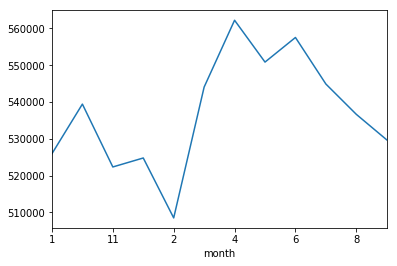

In [60]:
avgsalesbymonth.plot()